In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from numpy.typing import NDArray
import matplotlib.pyplot as plt
import utils_fc as utils
from scipy.optimize import minimize
from scipy import stats
from tqdm import tqdm
import time

In [3]:
dataloader = utils.MRIDataLoader()

In [6]:
subject_id_default = 13620
subject_ids = dataloader.get_subject_ids()
mri_data = dataloader.get_img(subject_id_default, 'signal')
seg_data = dataloader.get_img(subject_id_default, 'seg')
TE_times = dataloader.get_TE_times()
roi_dict, roi_id_dict = dataloader.get_roi_dicts()
thresh_default = 0.9
slice_default=25

In [7]:
problem_one_compartment = utils.create_problem_to_minimize('one_compartment')
problem_two_compartment = utils.create_problem_to_minimize('two_compartment')
problem_two_v_compartment = utils.create_problem_to_minimize('two_compartment_v')

rois = ['WM', 'GM', 'CSF']

### Fit 4 models on 200 voxels 100 times. Calculate the number of times the global minimum is hit (assuming it is found once)

In [41]:
answers = []
timings = []
nb_rand = 200
nb_repeat = 100

rois = ['WM', 'GM', 'CSF']
problems = [{'model': utils.model_one_compartment, 'name': 'linear_least_squares'},
            {'model': utils.model_one_compartment,   'problem': problem_one_compartment,   'bounds': None, 'x0': np.array([5000, 50]), 'name': 'one_compartment'},
            {'model': utils.model_multi_compartment, 'problem': problem_two_compartment,   'bounds': None, 'x0': np.array([5000, 50, 60]), 'name': 'two_compartment'},
            {'model': utils.model_multi_compartment, 'problem': problem_two_v_compartment, 'bounds': None, 'x0': np.array([5000, 50, 60, 0.8]), 'name': 'two_compartment_v'}]
seg = seg_data[:,:,slice_default].reshape((-1,6))
data = mri_data[:,:,slice_default].reshape((-1,10))
is_mono = utils.is_monotonic_index(data)
is_solve = seg[:,0]
is_mono_solve = (is_mono * is_solve).astype(bool)
data_is_mono = data[is_mono_solve]
seg_is_mono = seg[is_mono_solve]
rand_vox_id = np.random.randint(low=0, high=is_mono_solve.sum(), size=nb_rand)
data = data_is_mono[rand_vox_id]
seg = seg_is_mono[rand_vox_id]

for i, problem_dict in enumerate(problems):
    answers.append([])
    timings.append([])
    if problem_dict['name'] == 'linear_least_squares':
        
        start_time = time.time()
        T2, S0 = utils.lsqr_weighted(data[:,1:], seg[:,0], TE_times[1:])
        timings[i].append(time.time() - start_time)
        for repeat_id in range(nb_repeat):
            answers[i].append([T2, S0, TE_times])
    else:
        model, problem, bound, x0 = problem_dict['model'], problem_dict['problem'], problem_dict['bounds'], problem_dict['x0']
        model_name = problem_dict['name']
        std = x0 / 5
        nb_vox = data.shape[0]
        
        for repeat_id in tqdm(range(nb_repeat)):
            
            X0 = np.random.normal(x0, std, size=(nb_vox, len(x0)))
            # X0 = np.tile(x0, reps=nb_vox).reshape(nb_vox, -1)
        
            args_TE = np.tile(TE_times, reps=nb_vox).reshape(nb_vox, -1)
            
            v0 = seg[:,1:].max(axis=-1)
            v0 = np.where(v0 < 0.5, 0.5, v0)
            v = np.stack([v0, 1-v0], axis=-1)
            
            if model_name == 'one_compartment':
                args = [data[:,1:], args_TE[:,1:]]
            elif model_name == 'two_compartment':
                args = [data[:,1:], args_TE[:,1:], v]
            elif model_name == 'two_compartment_v':
                args = [data[:,1:], args_TE[:,1:]]
                
            start_time = time.time()
            answers_tmp = utils.minimize_given_problem(problem=problem, X0=X0, args_list=args, is_print_progress=False)
            timings[i].append(time.time() - start_time)
        
            if model_name == 'one_compartment':
                S0, T2 = answers_tmp
                answers[i].append([T2, S0, TE_times])
            elif model_name in ['two_compartment', 'two_compartment_given_T']:
                S0, T2_0, T2_1 = answers_tmp
                T2 = np.stack([T2_0, T2_1], axis=-1)
                answers[i].append([T2, S0, TE_times, v])
            elif model_name in ['two_compartment_v', 'two_compartment_v_given_T']:
                S0, T2_0, T2_1, v0 = answers_tmp
                T2 = np.stack([T2_0, T2_1], axis=-1)
                v = np.stack([v0, 1 - v0], axis=-1)
                answers[i].append([T2, S0, TE_times, v])
timings = np.array(timings)
    

c:\Users\fl_cl\OneDrive - University College London\Visual Studio 2017\Biomedical-imaging\report\utils_fc.py:76: RuntimeWarning: divide by zero encountered in divide
  T2 = (-1) / X[:,1]
100%|██████████| 100/100 [13:10<00:00,  7.90s/it]


In [121]:
# Calculate the RMSE for all fitted models
N = [2, 2, 3, 4]
rmse_list = []
aic_list = []
for problem_id in range(len(answers)):
    rmse_list.append([])
    aic_list.append([])
    for j in range(len(answers[problem_id])):
        if problem_id == 0:
            model = utils.model_one_compartment
        else:
            model = problems[problem_id]['model']
        signal_est = model(*answers[problem_id][j])
        rmse = utils.RMSE(data, signal_est, dim=-1)
        rmse_list[problem_id].append(rmse)
        aic_mean = utils.AIC(data, signal_est, N[problem_id]).mean()
        aic_list[problem_id].append(aic_mean)
rmse_array = np.array(rmse_list)
aic_array = np.array(aic_list)

linear_least_squares - mean RMSE: 1557.01
one_compartment - mean RMSE: 79.39
two_compartment - mean RMSE: 76.83
two_compartment_v - mean RMSE: 71.73

linear_least_squares - best RMSE: 1557.01
one_compartment - best RMSE: 79.39
two_compartment - best RMSE: 76.09
two_compartment_v - best RMSE: 68.30

linear_least_squares - Fitting: 0.015s
one_compartment - Fitting: 1.650s
two_compartment - Fitting: 2.489s
two_compartment_v - Fitting: 7.902s

linear_least_squares - AIC: 152.486s
one_compartment - AIC: 90.932s
two_compartment - AIC: 92.206s
two_compartment_v - AIC: 92.229s


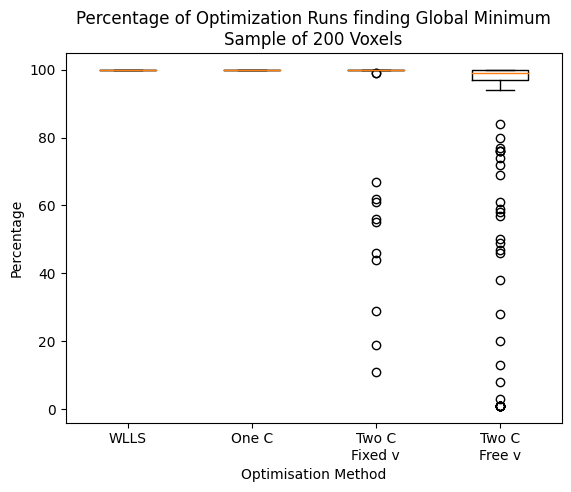

In [137]:
# Average RMSE:
for model_id, problem_dict in enumerate(problems):
    model_name = problem_dict['name']
    print(f'{model_name} - mean RMSE: {rmse_array[model_id].mean():.2f}')    # [p,r,v]
print('')

# best average RMSE
best_rmse = rmse_array.min(axis=1)  # [p,v]
for model_id, problem_dict in enumerate(problems):
    model_name = problem_dict['name']
    print(f'{model_name} - best RMSE: {best_rmse[model_id].mean():.2f}')
print('')

# Time for each 200 voxel fit
for model_id, problem_dict in enumerate(problems):
    model_name = problem_dict['name']
    print(f'{model_name} - Fitting: {timings.mean(axis=1)[model_id]:.3f}s')
print('')

# AIC
for model_id, problem_dict in enumerate(problems):
    model_name = problem_dict['name']
    print(f'{model_name} - AIC: {aic_array[model_id].mean(axis=-1):.3f}s')


rmse_min_same_shape = np.einsum('ij,k->ikj', best_rmse, np.ones(nb_repeat))
nb_global_min = np.isclose(rmse_array, rmse_min_same_shape, rtol=0.1)

plt.boxplot(nb_global_min.sum(axis=1).swapaxes(0,1), labels=['WLLS', 'One C', 'Two C\nFixed v', 'Two C\nFree v'])
plt.title('Percentage of Optimization Runs finding Global Minimum\nSample of 200 Voxels')
plt.xlabel('Optimisation Method')
plt.ylabel('Percentage')
plt.show()

### Using the two_compartment objective, fit to a slice of MRI and visalise

In [11]:
data = dataloader.get_img(subject_id_default, 'signal')[:,:,slice_default,:].reshape((-1,10))
seg = dataloader.get_img(subject_id_default, 'seg')[:,:,slice_default,:].reshape((-1,6))

brain_id = roi_dict['brain']
is_solve_for = seg[:,brain_id].astype(bool)
nb_vox = data.shape[0]

x0 = np.array([5000, 50, 60])
X0 = np.tile(x0, reps=nb_vox).reshape(nb_vox, -1)
args_TE = np.tile(TE_times, reps=nb_vox).reshape(nb_vox, -1)

v0 = seg[:,1:].max(axis=-1)
v0 = np.where(v0 < 0.5, 0.5, v0)
v = np.stack([v0, 1-v0], axis=-1)

args = [data[:,1:], args_TE[:,1:], v]

S0, T2_0, T2_1 = utils.minimize_given_problem(problem=problem_two_compartment, X0=X0, args_list=args, is_solve_for=is_solve_for, is_print_progress=True)
T2 = np.stack([T2_0, T2_1], axis=-1)

S0 = S0.reshape(96,96)
T2 = T2.reshape(96,96,-1)
data = data.reshape(96,96,-1)
seg = seg.reshape(96,96,-1)
v = v.reshape(96,96,-1)

100%|##########| 9216/9216 [00:34<00:00, 263.55it/s]  


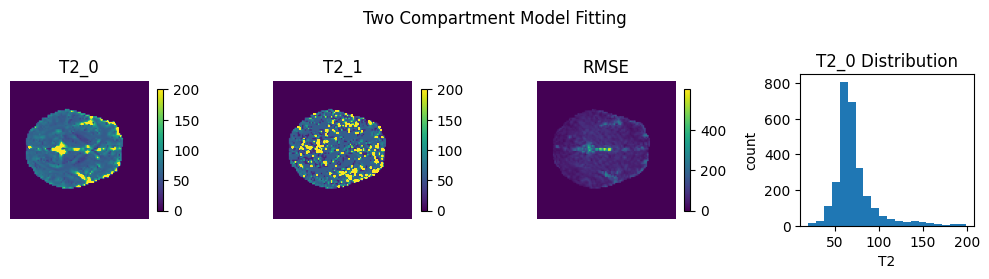

In [60]:
signal_est = utils.model_multi_compartment(T2, S0, TE_times, v.reshape(96,96,-1))
rmse = utils.RMSE(data, signal_est) * is_solve_for.reshape(96,96)

fig, axs = plt.subplots(1,4, figsize=(10,2.8))
fig.suptitle('Two Compartment Model Fitting')

im = axs[0].imshow(T2[:,:,0], vmax=200)
axs[0].set_title('T2_0')
cbar = fig.colorbar(im, ax=axs[0], shrink=0.8)
axs[0].axis('off')

im = axs[1].imshow(T2[:,:,1], vmax=200)
axs[1].set_title('T2_1')
cbar = fig.colorbar(im, ax=axs[1], shrink=0.8)
axs[1].axis('off')

im = axs[2].imshow(rmse)
axs[2].set_title('RMSE')
cbar = fig.colorbar(im, ax=axs[2], shrink=0.8)
axs[2].axis('off')

t2 = T2.reshape(-1,2)[:,0]
is_show = is_solve_for * (t2 < 200)
t2 = t2[is_show]
axs[3].hist(t2,bins=20)
axs[3].set_title('T2_0 Distribution')
axs[3].set_ylabel('count')
axs[3].set_xlabel('T2')

fig.tight_layout()

c:\Users\fl_cl\OneDrive - University College London\Visual Studio 2017\Biomedical-imaging\report\utils_fc.py:95: RuntimeWarning: divide by zero encountered in divide
  T2_inv = 1/T2
c:\Users\fl_cl\OneDrive - University College London\Visual Studio 2017\Biomedical-imaging\report\utils_fc.py:130: RuntimeWarning: divide by zero encountered in divide
  T2_inv = 1/T2
C:\Users\fl_cl\AppData\Local\Temp\ipykernel_21912\3413542257.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


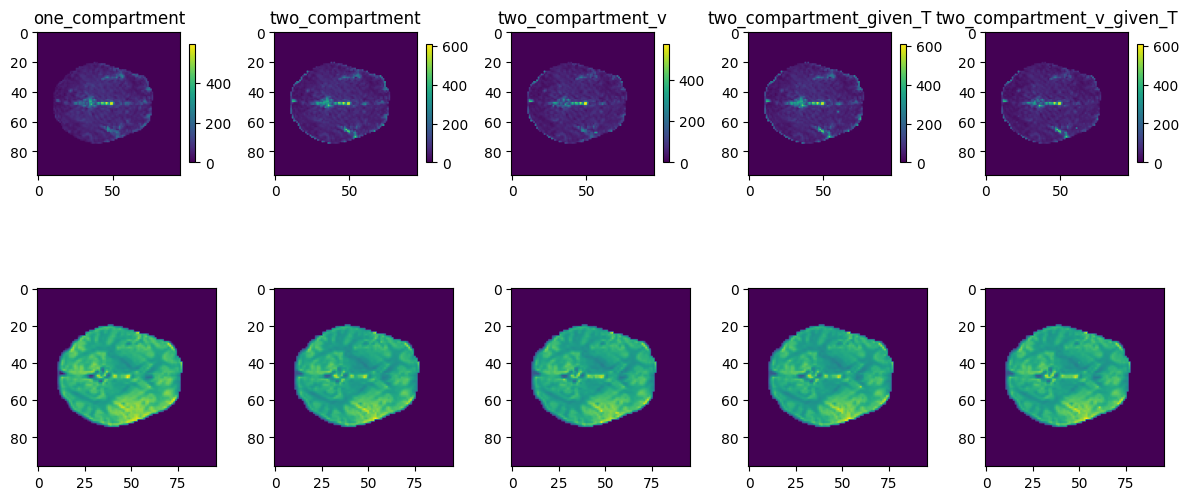

In [125]:
rmse = []
fig, axs = plt.subplots(2,len(non_linear_problems), figsize=(12,6))

for ax_id, non_linear_problem in enumerate(non_linear_problems):
    model = non_linear_problem['model']
    signal_est = model(*answers[ax_id])
    rmse.append(utils.RMSE(signal_est, data, dim=-1) * is_solve)
    im = axs[0,ax_id].imshow(rmse[ax_id].reshape(96,96))
    cbar = fig.colorbar(im, ax=axs[0,ax_id], shrink=0.4)
    axs[0,ax_id].set_title(non_linear_problem['name'])
    
    axs[1,ax_id].imshow(signal_est.reshape(96,96,10)[:,:,0])
fig.tight_layout()
fig.show()

In [ ]:
mri_data_flatten = mri_data.reshape(-1, mri_data.shape[-1])
seg_data_flatten = seg_data.reshape(-1, seg_data.shape[-1])

x0 = np.array([5000, 50, 60])
roi_answers = []
nb_roi_select_max = 1000

for roi_id in tqdm(roi_id_dict, ascii=True):
    roi = roi_id_dict[roi_id]
    print(f'Solving {roi}...')
    roi_data_total = mri_data_flatten[seg_data_flatten[:,roi_id] > thresh_default]
    roi_seg_data_total = seg_data_flatten[seg_data_flatten[:,roi_id] > thresh_default]
    nb_roi_total = roi_data_total.shape[0]
    nb_roi_select = min([nb_roi_total, nb_roi_select_max])
    
    roi_rand_ids = np.random.randint(low=0, high=nb_roi_total, size=nb_roi_select)
    roi_data = roi_data_total[roi_rand_ids]
    roi_seg_data = roi_seg_data_total[roi_rand_ids]
    
    print(f'{nb_roi_total} total voxels, calculating with {nb_roi_select} of them')
    
    X0 = np.tile(x0, reps=nb_roi_select).reshape(nb_roi_select, -1)
    args_TE = np.tile(TE_times, reps=nb_roi_select).reshape(nb_roi_select, -1)
    v0 = roi_seg_data[:,1:].max(axis=-1)
    v0 = np.where(v0 < 0.5, 0.5, v0)
    v = np.stack([v0, 1-v0], axis=-1)
    # args_10 = [roi_data, args_TE, v]
    args_9  = [roi_data[:,1:], args_TE[:,1:], v]    # missing out the first TE signal due to very low T2 value distorting signal
    # S0_10, T2_0_10, T2_1_10 = utils.minimize_given_problem(problem=problem_two_compartment, X0=X0, args_list=args_10, is_print_progress=True)
    S0, T2_0, T2_1 = utils.minimize_given_problem(problem=problem_two_compartment, X0=X0, args_list=args_9, is_print_progress=False)
    
    # T2_10 = np.stack([T2_0_10, T2_1_10], axis=-1)
    T2 = np.stack([T2_0, T2_1], axis=-1)
    signal_est = utils.model_multi_compartment(T2, S0, TE_times, v)
    rmse = utils.RMSE(roi_data, signal_est, dim=-1)
    roi_answers.append([S0, T2, v, rmse])

In [5]:
mri_data_flatten = mri_data.reshape(-1, mri_data.shape[-1])
seg_data_flatten = seg_data.reshape(-1, seg_data.shape[-1])

x0 = np.array([5000, 50, 60])
roi_answers = []
nb_roi_select_max = 1000

for roi_id in tqdm(roi_id_dict, ascii=True):
    roi = roi_id_dict[roi_id]
    print(f'Solving {roi}...')
    roi_data_total = mri_data_flatten[seg_data_flatten[:,roi_id] > thresh_default]
    roi_seg_data_total = seg_data_flatten[seg_data_flatten[:,roi_id] > thresh_default]
    nb_roi_total = roi_data_total.shape[0]
    nb_roi_select = min([nb_roi_total, nb_roi_select_max])
    
    roi_rand_ids = np.random.randint(low=0, high=nb_roi_total, size=nb_roi_select)
    roi_data = roi_data_total[roi_rand_ids]
    roi_seg_data = roi_seg_data_total[roi_rand_ids]
    
    print(f'{nb_roi_total} total voxels, calculating with {nb_roi_select} of them')
    
    X0 = np.tile(x0, reps=nb_roi_select).reshape(nb_roi_select, -1)
    args_TE = np.tile(TE_times, reps=nb_roi_select).reshape(nb_roi_select, -1)
    v0 = roi_seg_data[:,1:].max(axis=-1)
    v0 = np.where(v0 < 0.5, 0.5, v0)
    v = np.stack([v0, 1-v0], axis=-1)
    # args_10 = [roi_data, args_TE, v]
    args_9  = [roi_data[:,1:], args_TE[:,1:], v]    # missing out the first TE signal due to very low T2 value distorting signal
    # S0_10, T2_0_10, T2_1_10 = utils.minimize_given_problem(problem=problem_two_compartment, X0=X0, args_list=args_10, is_print_progress=True)
    S0, T2_0, T2_1 = utils.minimize_given_problem(problem=problem_two_compartment, X0=X0, args_list=args_9, is_print_progress=False)
    
    # T2_10 = np.stack([T2_0_10, T2_1_10], axis=-1)
    T2 = np.stack([T2_0, T2_1], axis=-1)
    signal_est = utils.model_multi_compartment(T2, S0, TE_times, v)
    rmse = utils.RMSE(roi_data, signal_est, dim=-1)
    roi_answers.append([S0, T2, v, rmse])

  0%|          | 0/6 [00:00<?, ?it/s]

Solving brain...
81248 total voxels, calculating with 1000 of them


 17%|#6        | 1/6 [00:11<00:58, 11.74s/it]

Solving CSF...
9669 total voxels, calculating with 1000 of them


 33%|###3      | 2/6 [00:21<00:42, 10.66s/it]

Solving GM...
24190 total voxels, calculating with 1000 of them


 50%|#####     | 3/6 [00:33<00:33, 11.05s/it]

Solving WM...
20666 total voxels, calculating with 1000 of them


 67%|######6   | 4/6 [00:43<00:21, 10.69s/it]

Solving DeepGM...
1875 total voxels, calculating with 1000 of them


 83%|########3 | 5/6 [00:53<00:10, 10.51s/it]

Solving brainstem...
924 total voxels, calculating with 924 of them


100%|##########| 6/6 [01:02<00:00, 10.35s/it]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


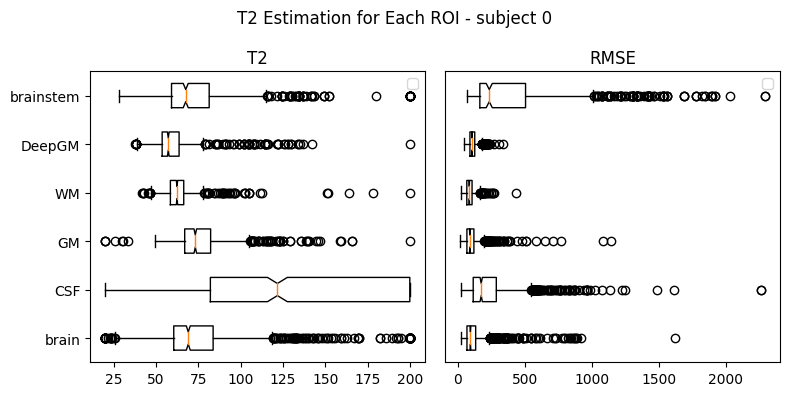

In [10]:
fig, axs = plt.subplots(1,2, figsize=(8,4))
fig.suptitle(f'T2 Estimation for Each ROI - subject {subject_id_default}')

T2_list = []
rmse_list = []
labels = []

for roi_id in roi_id_dict:
    roi = roi_id_dict[roi_id]
    labels.append(roi)
    S0 = roi_answers[roi_id][0]
    T2 = roi_answers[roi_id][1]
    v = roi_answers[roi_id][2]
    rmse = roi_answers[roi_id][3]
    
    T2_list.append(T2[:,0])
    rmse_list.append(rmse)

axs[0].boxplot(T2_list, labels, vert=False)
axs[0].set_title('T2')
axs[0].set_yticklabels(labels)
axs[0].legend()

axs[1].boxplot(rmse_list, labels, vert=False)
axs[1].set_title('RMSE')
axs[1].set_yticks([])
axs[1].legend()


# axs[0].hist(T2_09[:,0], label='0.9', alpha=0.5, bins=30)
# axs[0].hist(T2_06[:,0], label='0.6', alpha=0.5, bins=30)
# axs[0].set_title('T2 for different thresh')
# axs[0].legend()

# axs[1].hist(T2_10[:,1], label='10', alpha=0.5)
# axs[1].hist(T2_9[:,1], label='9', alpha=0.5)
# axs[1].set_title('T2_1')
# axs[1].legend()

fig.tight_layout()

### Now repeat but removing non-monotonic signals

In [12]:
mri_data_flatten = mri_data.reshape(-1, mri_data.shape[-1])
seg_data_flatten = seg_data.reshape(-1, seg_data.shape[-1])

x0 = np.array([5000, 50, 60])
roi_mono_answers = []
nb_roi_select_max = 1000

for roi_id in tqdm(roi_id_dict, ascii=True):
    roi = roi_id_dict[roi_id]
    print(f'Solving {roi}...')
    roi_data_total = mri_data_flatten[seg_data_flatten[:,roi_id] > thresh_default]
    roi_seg_data_total = seg_data_flatten[seg_data_flatten[:,roi_id] > thresh_default]
    
    is_mono_total = utils.is_monotonic_index(roi_data_total)
    roi_seg_data_total_mono = roi_seg_data_total[is_mono_total]
    roi_data_total_mono = roi_data_total[is_mono_total]
    
    nb_roi_total_mono = roi_data_total_mono.shape[0]
    nb_roi_select = min([nb_roi_total_mono, nb_roi_select_max])
    
    roi_rand_ids = np.random.randint(low=0, high=nb_roi_total_mono, size=nb_roi_select)
    roi_data = roi_data_total_mono[roi_rand_ids]
    roi_seg_data = roi_seg_data_total_mono[roi_rand_ids]
    
    print(f'{nb_roi_total_mono} total monotonic voxels, calculating with {nb_roi_select} of them')
    
    X0 = np.tile(x0, reps=nb_roi_select).reshape(nb_roi_select, -1)
    args_TE = np.tile(TE_times, reps=nb_roi_select).reshape(nb_roi_select, -1)
    v0 = roi_seg_data[:,1:].max(axis=-1)
    v0 = np.where(v0 < 0.5, 0.5, v0)
    v = np.stack([v0, 1-v0], axis=-1)
    # args_10 = [roi_data, args_TE, v]
    args_9  = [roi_data[:,1:], args_TE[:,1:], v]    # missing out the first TE signal due to very low T2 value distorting signal
    # S0_10, T2_0_10, T2_1_10 = utils.minimize_given_problem(problem=problem_two_compartment, X0=X0, args_list=args_10, is_print_progress=True)
    S0, T2_0, T2_1 = utils.minimize_given_problem(problem=problem_two_compartment, X0=X0, args_list=args_9, is_print_progress=False)
    
    # T2_10 = np.stack([T2_0_10, T2_1_10], axis=-1)
    T2 = np.stack([T2_0, T2_1], axis=-1)
    signal_est = utils.model_multi_compartment(T2, S0, TE_times, v)
    rmse = utils.RMSE(roi_data, signal_est, dim=-1)
    roi_mono_answers.append([S0, T2, v, rmse])

  0%|          | 0/6 [00:00<?, ?it/s]

Solving brain...
61325 total monotonic voxels, calculating with 1000 of them


 17%|#6        | 1/6 [00:11<00:59, 11.97s/it]

Solving CSF...
7551 total monotonic voxels, calculating with 1000 of them


 33%|###3      | 2/6 [00:21<00:41, 10.43s/it]

Solving GM...
18637 total monotonic voxels, calculating with 1000 of them


 50%|#####     | 3/6 [00:32<00:32, 10.69s/it]

Solving WM...
13448 total monotonic voxels, calculating with 1000 of them


 67%|######6   | 4/6 [00:42<00:20, 10.29s/it]

Solving DeepGM...
1187 total monotonic voxels, calculating with 1000 of them


 83%|########3 | 5/6 [00:51<00:10, 10.10s/it]

Solving brainstem...
495 total monotonic voxels, calculating with 495 of them


100%|##########| 6/6 [00:56<00:00,  9.39s/it]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


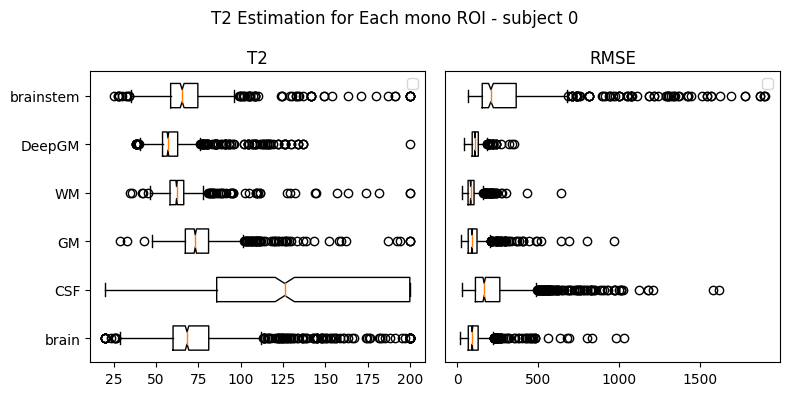

In [13]:
fig, axs = plt.subplots(1,2, figsize=(8,4))
fig.suptitle(f'T2 Estimation for Each mono ROI - subject {subject_id_default}')

T2_list = []
rmse_list = []
labels = []

for roi_id in roi_id_dict:
    roi = roi_id_dict[roi_id]
    labels.append(roi)
    S0 = roi_mono_answers[roi_id][0]
    T2 = roi_mono_answers[roi_id][1]
    v = roi_mono_answers[roi_id][2]
    rmse = roi_mono_answers[roi_id][3]
    
    T2_list.append(T2[:,0])
    rmse_list.append(rmse)

axs[0].boxplot(T2_list, labels, vert=False)
axs[0].set_title('T2')
axs[0].set_yticklabels(labels)
axs[0].legend()

axs[1].boxplot(rmse_list, labels, vert=False)
axs[1].set_title('RMSE')
axs[1].set_yticks([])
axs[1].legend()


# axs[0].hist(T2_09[:,0], label='0.9', alpha=0.5, bins=30)
# axs[0].hist(T2_06[:,0], label='0.6', alpha=0.5, bins=30)
# axs[0].set_title('T2 for different thresh')
# axs[0].legend()

# axs[1].hist(T2_10[:,1], label='10', alpha=0.5)
# axs[1].hist(T2_9[:,1], label='9', alpha=0.5)
# axs[1].set_title('T2_1')
# axs[1].legend()

fig.tight_layout()

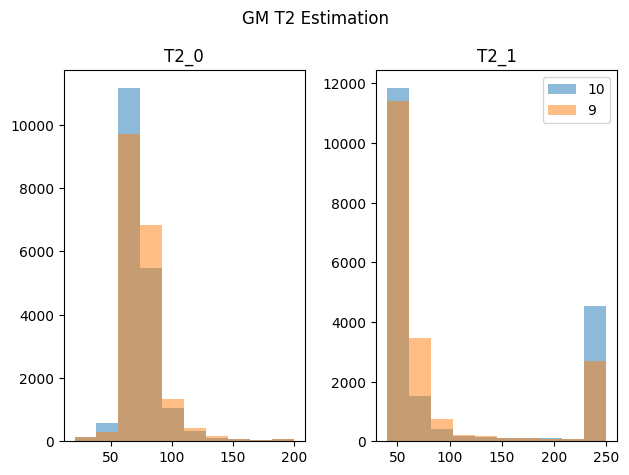

In [ ]:
fig, axs = plt.subplots(1,2)
fig.suptitle(f'{roi} T2 Estimation')

axs[0].hist(T2_10[:,0], label='10', alpha=0.5)
axs[0].hist(T2_9[:,0], label='9', alpha=0.5)
axs[0].set_title('T2_0')

axs[1].hist(T2_10[:,1], label='10', alpha=0.5)
axs[1].hist(T2_9[:,1], label='9', alpha=0.5)
axs[1].set_title('T2_1')
axs[1].legend()

fig.tight_layout()

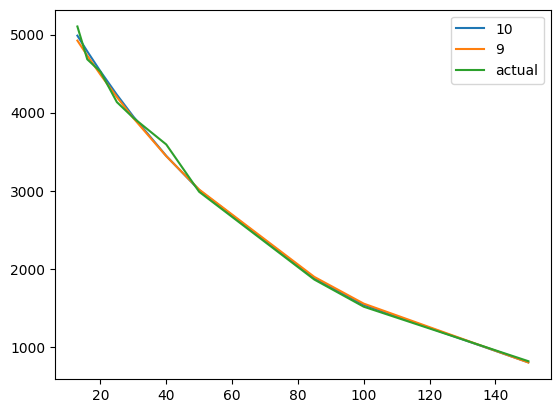

In [ ]:
vox_id = 462

signal_est_10 = utils.model_multi_compartment(T2_10[vox_id].reshape(1,2), S0_10[vox_id], TE_times, v[vox_id].reshape(1,2))
signal_est_9 = utils.model_multi_compartment(T2_9[vox_id].reshape(1,2), S0_9[vox_id], TE_times, v[vox_id].reshape(1,2))
signal = roi_data[vox_id]

plt.plot(TE_times, signal_est_10[0], label='10')
plt.plot(TE_times, signal_est_9[0], label='9')
plt.plot(TE_times, signal, label='actual')
plt.legend()
